In [1]:
import mediapipe as mp
import cv2 as cv
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# 1.0 Assessing the tools, etc (testing)

## 1.1 Joint Determinations through an active feed
<img src="joints.png" style="height:300px" >

The following joints are everything thats considered through the use of mediapipe to assess joints

In [2]:
cap = cv.VideoCapture(0)

# Using the Pose model with specific confidence thresholds
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Recolouring the image
        image = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        image.flags.writeable = False  # Prevents unnecessary caching

        # Make pose detection
        results = pose.process(image)

        # Recolor the image back to BGR
        image.flags.writeable = True
        image = cv.cvtColor(image, cv.COLOR_RGB2BGR)

        try:
            # Get pose landmarks
            landmarks = results.pose_landmarks.landmark

            # Get normalized x and y coordinates for all landmarks
            height, width, _ = image.shape
            x_coords = [landmark.x * width for landmark in landmarks]
            y_coords = [landmark.y * height for landmark in landmarks]

            # Calculate bounding box
            x_min, x_max = int(min(x_coords)), int(max(x_coords))
            y_min, y_max = int(min(y_coords)), int(max(y_coords))

            # Draw the bounding box
            cv.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            # Calculate and print height and width of the bounding box
            box_width = x_max - x_min
            box_height = y_max - y_min
            if (box_height<box_width):
                print("\n---\nheight less than width!\n---\n")
            print(f"Bounding Box: Width={box_width}, Height={box_height}")

            # Extract RIGHT_WRIST and LEFT_WRIST positions
            right_wrist = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST]
            left_wrist = landmarks[mp_pose.PoseLandmark.LEFT_WRIST]

            # Print RIGHT_WRIST and LEFT_WRIST data if visible
            if right_wrist.visibility > 0.5 and left_wrist.visibility > 0.5:
                print(f"RIGHT_WRIST: x={right_wrist.x}, y={right_wrist.y}, z={right_wrist.z}, visibility={right_wrist.visibility}")
                print(f"LEFT_WRIST: x={left_wrist.x}, y={left_wrist.y}, z={left_wrist.z}, visibility={left_wrist.visibility}")

        except AttributeError:
            pass

        # Render pose landmarks on the image
        mp_drawing.draw_landmarks(
            image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
            mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
        )

        # Display the image
        cv.imshow('Mediapipe Feed', image)

        # Break the loop if 'q' is pressed
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

# Release resources
cap.release()
cv.destroyAllWindows()


Bounding Box: Width=434, Height=1285
Bounding Box: Width=446, Height=1262
Bounding Box: Width=459, Height=1252
Bounding Box: Width=439, Height=1256
Bounding Box: Width=422, Height=1259
Bounding Box: Width=419, Height=1267
Bounding Box: Width=430, Height=1283
Bounding Box: Width=454, Height=1292
Bounding Box: Width=466, Height=1291
Bounding Box: Width=474, Height=1290
Bounding Box: Width=488, Height=1289
Bounding Box: Width=485, Height=1289
Bounding Box: Width=472, Height=1291
Bounding Box: Width=466, Height=1286
Bounding Box: Width=461, Height=1283
Bounding Box: Width=464, Height=1285
Bounding Box: Width=470, Height=1291
Bounding Box: Width=472, Height=1293
Bounding Box: Width=471, Height=1292
Bounding Box: Width=470, Height=1292
Bounding Box: Width=474, Height=1291
Bounding Box: Width=479, Height=1291
Bounding Box: Width=481, Height=1291
Bounding Box: Width=479, Height=1295
Bounding Box: Width=461, Height=1293
Bounding Box: Width=455, Height=1293
Bounding Box: Width=456, Height=1292
B

# 2.0 Exploratory Data Analysis

The normal process for exploratory data analysis is as follows, however the dataset must first be curated and created before exploring and processing it:

**The first three segments may be negated due to there being no unwanted columns of values (since the scaler ensure that each cell is fitted with a value) and there can be no features with just one value given each features variations**

- 2.1 Find Unwanted Columns 
- 2.2 Find Missing Values
- 2.3 Find Features with one value
- 2.4 Explore the Categorical Features
- 2.5 Find Categorical Feature Distribution
- 2.6 Relationship between Categorical Features and Label
- 2.7 Explore the Numerical Features
- 2.8 Find Discrete Numerical Features
- 2.9 Relation between Discrete numerical Features and Labels
- 2.10 Find Continous Numerical Features
- 2.11 Distribution of Continuous Numerical Features
- 2.12 Relation between Continuous numerical Features and Labels
- 2.13 Find Outliers in numerical features
- 2.14 Explore the Correlation between numerical features
- 2.15 Assessing the information gain
- 2.16 Check the Data set is balanced or not based on target values in classification

### 2.0.1 Reading through training data and marking coordinates into a csv file

>Whats happening here is simply a classification algorithm that mounts joints onto a person based on its visibility and then places a boundary box around the subject. Having done so the coordinates of these joints will be put into a CSV file alongside the image it was found in (the name of the image states if the person has fallen or not hence making it a trainable dataset

All that is happening here is that openCV is used to open an image detection frame and then media pipe is used to place joints over the images placed in that frame. Thereafter placing the joints, they will be put into a folder called "annotated images" and the image_name,coordinates (x,y), visibility, box_width and box_height will be put into a csv file to train the model. So, in other words the logic is as follows:

#### 2.0.1.1 What is being considered?

- First the joints will be applied onto the images present in the training data
- Having applied the joints onto each image a bounding box will be placed around them specifying the height against the width
    - Each of the coordinates for each joint will be scaled and considered
    - Bounding box heights are considered as it is a fundamental aspect to state that when the width is bigger than the height it means that someone is lying down
- The name of the joint, its visibility and coordinates will be listed out in a CSV file in order to enable the models to work around comparing the provided coordinates against the outcome such that if someone were to assume a specific position the model may assess if they were in a "falling position" or not 
- In terms of how each value was scaled, a min-max scaler was used such that the data is standardized and easier to understand and process in the models. The formula is as follows:

$
x = \frac{x-x_{min}}{x_{max}-x_{min}
$

#### 2.0.1.2 How is each feature relevant to the outcome?

>When considering if a person is going to fall or not in the provided dataset, the training data has named each image as fall or non-fall so that is what will be used as an outcome label. Regarding the other features, refer to the following to understand their relevance:

- **Image** - Used for the label
- **Join** - Specifies the name of the joint
- **X,Y** - Coordinates of each joint (fitted into the dataset with a scaler)
- **Visibility** - Marks out the visibility of the detected joint so that after the feature engineering segment, joints with a low visibility will be considered as anomalous data given their poor visibility (e.g. the only justification for this is that if a joint were to be poorly mounted onto a person it would have a poor visibility score, so having such a poor score would then enable the model to assume that the joint is obstructed hence enabling it to focus on the more important joints)
- **Box_Width, Box_Height** - The width and height of the bounding boxes 

In [6]:
import os
import cv2 as cv
import mediapipe as mp
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Path to the folder containing images
input_folder = r"C:\Users\Ethan\Documents\Codes\CM2603-Data_Science_Project-G20\Fall_Detection\fall_dataset\images\train"
output_csv = "image_train_pose_coordinates.csv"

# Initialize a DataFrame to store joint data
columns = ["Image", "Joint", "X", "Y", "Visibility", "Box_Width", "Box_Height"]
pose_data = []

# Joints to exclude
excluded_joints = {
    "NOSE", "LEFT_EYE_INNER", "LEFT_EYE", "LEFT_EYE_OUTER", "RIGHT_EYE_INNER", "RIGHT_EYE",
    "RIGHT_EYE_OUTER", "LEFT_EAR", "RIGHT_EAR", "MOUTH_LEFT", "MOUTH_RIGHT"
}

# Using the Pose model
with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3) as pose:
    for image_name in os.listdir(input_folder):
        image_path = os.path.join(input_folder, image_name)

        # Check if it's an image file
        if not (image_name.endswith(".jpg") or image_name.endswith(".png") or image_name.endswith(".jpeg")):
            print(f"Skipping non-image file: {image_name}")
            continue

        # Read the image
        image = cv.imread(image_path)
        if image is None:
            print(f"Skipping invalid image file: {image_name}")
            continue

        # Resize image for consistency and faster processing
        image = cv.resize(image, (640, 480))

        # Process the image
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        # Check if landmarks are detected
        if results.pose_landmarks and results.pose_landmarks.landmark:
            print(f"Pose landmarks detected for: {image_name}")
            landmarks = results.pose_landmarks.landmark
            height, width, _ = image.shape

            x_coords = []
            y_coords = []

            # Extract and save landmark data
            for idx, landmark in enumerate(landmarks):
                joint_name = mp_pose.PoseLandmark(idx).name
                if joint_name in excluded_joints:
                    continue

                x = landmark.x * width
                y = landmark.y * height
                visibility = landmark.visibility
                pose_data.append([image_name, joint_name, x, y, visibility, 0, 0])

                x_coords.append(x)
                y_coords.append(y)

            # Calculate bounding box (min/max coordinates)
            if x_coords and y_coords:
                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)

                box_width = x_max - x_min
                box_height = y_max - y_min

                # Update the CSV data with bounding box dimensions
                for i in range(len(pose_data)):
                    if pose_data[i][0] == image_name:
                        pose_data[i][5] = box_width
                        pose_data[i][6] = box_height

                # Draw landmarks on the image
                annotated_image = image.copy()
                mp_drawing.draw_landmarks(
                    annotated_image,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
                )

                # Draw the bounding box around the pose
                cv.rectangle(annotated_image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

                # Save the annotated image
                output_folder = "annotated_images"
                os.makedirs(output_folder, exist_ok=True)
                output_image_path = os.path.join(output_folder, f"annotated_{image_name}")
                cv.imwrite(output_image_path, annotated_image)
        else:
            print(f"No pose landmarks detected in: {image_name}")

# Convert data to DataFrame
pose_df = pd.DataFrame(pose_data, columns=columns)

# Apply Min-Max Scaling
scaler = MinMaxScaler()
pose_df[["X", "Y", "Visibility", "Box_Width", "Box_Height"]] = scaler.fit_transform(pose_df[["X", "Y", "Visibility", "Box_Width", "Box_Height"]])

# Save data to CSV
pose_df.to_csv(output_csv, index=False)
print(f"Pose coordinates with Min-Max Scaling saved to {output_csv}")


Pose landmarks detected for: fall001.jpg
No pose landmarks detected in: fall002.jpg
Pose landmarks detected for: fall003.jpg
Pose landmarks detected for: fall004.jpg
Pose landmarks detected for: fall005.jpg
Pose landmarks detected for: fall006.jpg
Pose landmarks detected for: fall007.jpg
No pose landmarks detected in: fall008.jpg
Pose landmarks detected for: fall009.jpg
Pose landmarks detected for: fall010.jpg
Pose landmarks detected for: fall011.jpg
Pose landmarks detected for: fall012.jpg
Pose landmarks detected for: fall013.jpg
Pose landmarks detected for: fall014.jpg
Pose landmarks detected for: fall015.jpg
Pose landmarks detected for: fall016.jpg
No pose landmarks detected in: fall017.jpg
Pose landmarks detected for: fall018.jpg
Pose landmarks detected for: fall019.jpg
Pose landmarks detected for: fall020.jpg
Pose landmarks detected for: fall021.jpg
Pose landmarks detected for: fall022.jpg
Pose landmarks detected for: fall023.jpg
Pose landmarks detected for: fall024.jpg
Pose landm

## 2.4 Plotting out the categorical features

There are only two categorical features:
- Image 
- Joint

In [7]:
import pandas as pd

file_path = "image_train_pose_coordinates.csv"
df = pd.read_csv(file_path)

categorical_features = [feature for feature in df.columns if df[feature].dtype == 'object']

for feature in categorical_features:
    print(f"The feature is '{feature}' whereas the number of values for the feature is: {df[feature].nunique()}")

print(f"There are {len(categorical_features)} categorical features.")


The feature is 'Image' whereas the number of values for the feature is: 314
The feature is 'Joint' whereas the number of values for the feature is: 22
There are 2 categorical features.


## 2.5 Plotting out the categorical feature distribution

> This was done in order to see how much each unique value in each feature had contributed to the outcome of the dataset

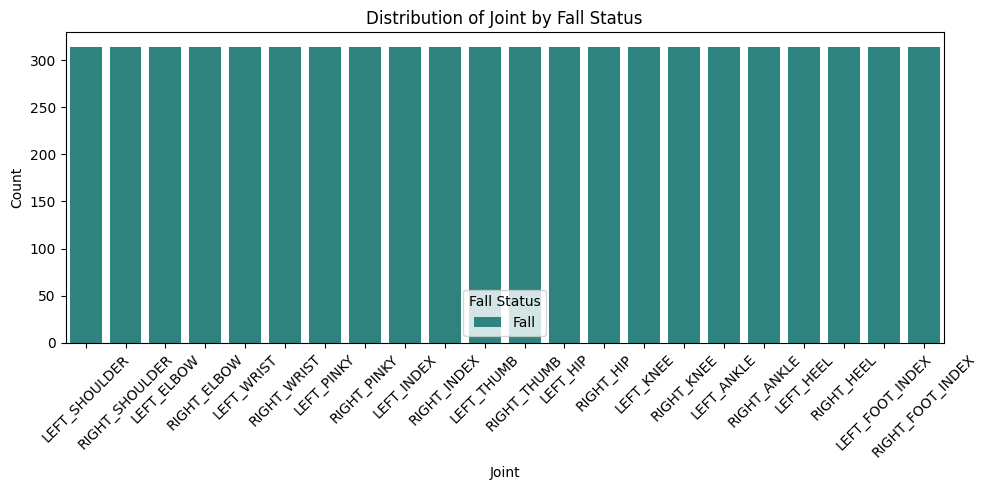

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = "image_train_pose_coordinates.csv"
df = pd.read_csv(file_path)

# Define a function to classify images as "Fall" or "Non-Fall"
def classify_fall_status(image_name):
    image_name = str(image_name).lower()  # Convert to lowercase for consistency
    if "fall" in image_name and "not_fall" not in image_name:
        return "Fall"
    return "Non-Fall"

# Create a new DataFrame with the outcome label
df["Fall_Status"] = df["Image"].apply(classify_fall_status)

# Identify categorical features (excluding 'Image' and 'Fall_Status')
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'object' and feature not in ["Image", "Fall_Status"]]

# Plot distribution of each categorical feature against Fall_Status
num_features = len(categorical_features)
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Ensure axes is iterable for a single feature case
if num_features == 1:
    axes = [axes]

# Plot each categorical feature's distribution grouped by Fall_Status
for ax, feature in zip(axes, categorical_features):
    sns.countplot(x=df[feature], hue=df["Fall_Status"], ax=ax, palette="viridis")
    ax.set_title(f"Distribution of {feature} by Fall Status")
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=45)  # Rotate x labels for better readability
    ax.legend(title="Fall Status")

plt.tight_layout()
plt.show()


## 2.6 Relationship between categorical features and label

**Plotting the image feature was excluded as each row was simply a different image name**

It may however be found that:
- The number of falls supercede the non-falls
- There is very little variation between the joints given the fact that they are all evemly distrbuted

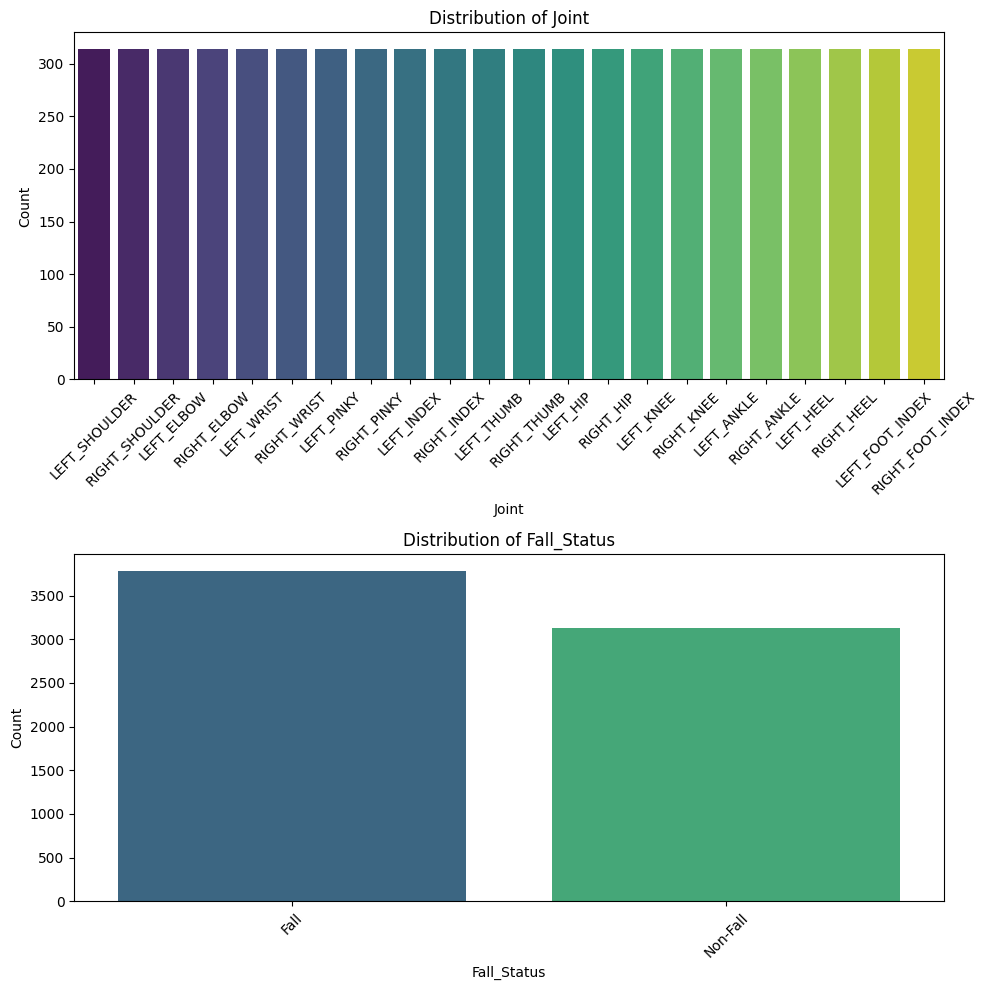

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = "image_train_pose_coordinates.csv"
df = pd.read_csv(file_path)

# Define a function to classify images as "Fall" or "Non-Fall"
def classify_fall_status(image_name):
    image_name = str(image_name).lower()  # Convert to lowercase for consistency
    if "not fallen" in image_name:
        return "Non-Fall"
    return "Fall"

# Create a new DataFrame with the outcome label
df["Fall_Status"] = df["Image"].apply(classify_fall_status)

# Identify all categorical features (excluding 'Image' column)
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'object' and feature != "Image" or feature == "Fall_Status"]

# Plot distribution of each categorical feature
num_cat_features = len(categorical_features)
fig, axes = plt.subplots(nrows=num_cat_features, ncols=1, figsize=(10, 5 * num_cat_features))

# Ensure axes is iterable for a single feature case
if num_cat_features == 1:
    axes = [axes]

# Plot each categorical feature's distribution
for ax, feature in zip(axes, categorical_features):
    sns.countplot(x=df[feature], hue=df[feature], ax=ax, palette="viridis", legend=False)
    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=45)  # Rotate x labels for better readability

plt.tight_layout()
plt.show()


## 2.7 Exploring the numerical features

In [22]:
import pandas as pd

file_path = "image_train_pose_coordinates.csv"
df = pd.read_csv(file_path)

# Identify all numerical features
numerical_features = [feature for feature in df.columns if df[feature].dtype in ['int64', 'float64']]

# Print the numerical features and their number of unique values
for feature in numerical_features:
    print(f"The feature is '{feature}' whereas the number of values for the feature is: {df[feature].nunique()}")

print(f"There are {len(numerical_features)} numerical features.")


The feature is 'X' whereas the number of values for the feature is: 6905
The feature is 'Y' whereas the number of values for the feature is: 6905
The feature is 'Visibility' whereas the number of values for the feature is: 6898
The feature is 'Box_Width' whereas the number of values for the feature is: 314
The feature is 'Box_Height' whereas the number of values for the feature is: 314
There are 5 numerical features.


## 2.8 Find discrete numerical features

> Discrete numerical features are typically integer-type features that have a limited number of distinct values, unlike continuous numerical features which may have many unique values within a range. So, since there are no discrete numerical features, 2.9 may be skipped whereas 2.10 may be skipped as well given the fact that all the variables here are continuous 

In [24]:
import pandas as pd

file_path = "image_train_pose_coordinates.csv"
df = pd.read_csv(file_path)

# Identify all numerical features
numerical_features = [feature for feature in df.columns if df[feature].dtype in ['int64', 'float64']]

# Find discrete numerical features (integer features with a small number of unique values)
discrete_numerical_features = [feature for feature in numerical_features if df[feature].dtype == 'int64' and df[feature].nunique() < 20]

# Print the discrete numerical features and their number of unique values
for feature in discrete_numerical_features:
    print(f"The feature is '{feature}' whereas the number of values for the feature is: {df[feature].nunique()}")

print(f"There are {len(discrete_numerical_features)} discrete numerical features.")


There are 0 discrete numerical features.


## 2.11 Plotting the distribution between the continuous numerical features and the label

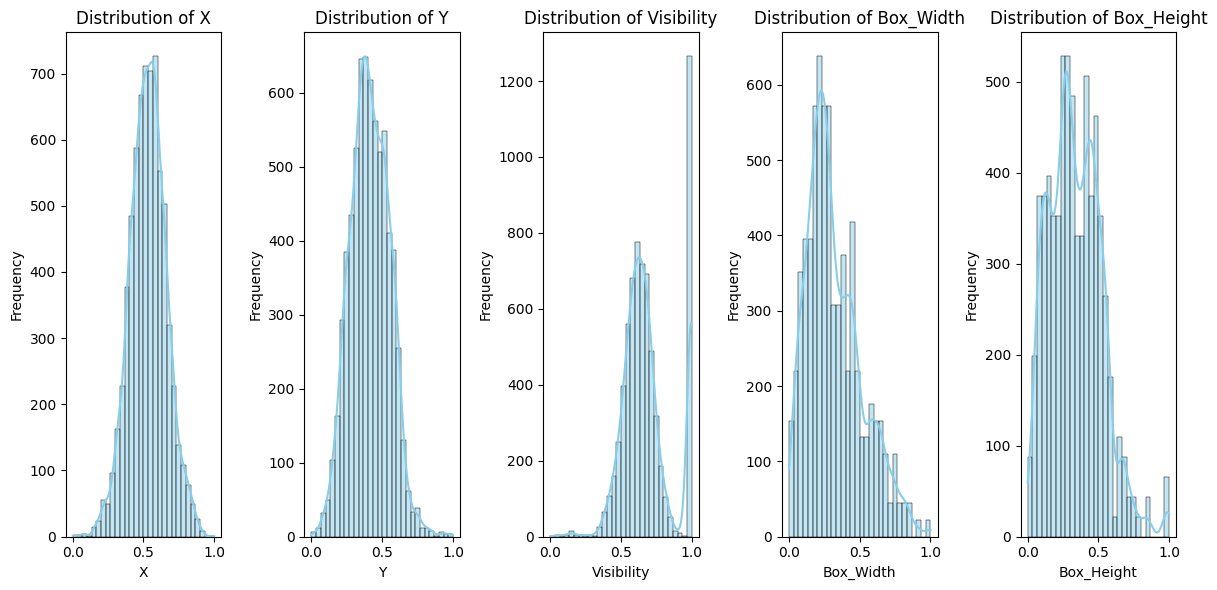

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "image_train_pose_coordinates.csv"
df = pd.read_csv(file_path)

# Identify numerical features
numerical_features = [feature for feature in df.columns if df[feature].dtype in ['int64', 'float64']]

# Create a histogram or KDE plot for each numerical feature
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, len(numerical_features), i)
    sns.histplot(df[feature], kde=True, color="skyblue", bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


## 2.12 Plotting the relation between the continuous numerical features and the label

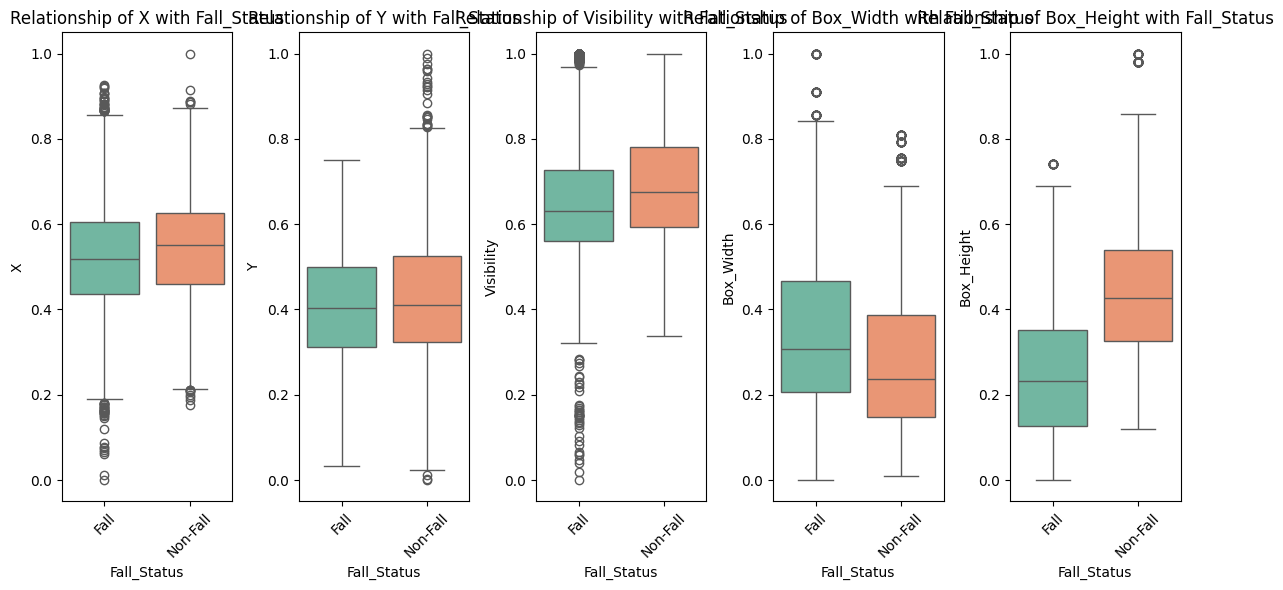

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "image_train_pose_coordinates.csv"
df = pd.read_csv(file_path)

# Define the function to classify images as "Fall" or "Non-Fall"
def classify_fall_status(image_name):
    image_name = str(image_name).lower()  # Convert to lowercase for consistency
    if "not fallen" in image_name:
        return "Non-Fall"
    return "Fall"

# Create a new DataFrame with the 'Fall_Status' column
df['Fall_Status'] = df['Image'].apply(classify_fall_status)

# Identify continuous numerical features
continuous_features = [feature for feature in df.columns if df[feature].dtype in ['float64']]

# Create a box plot for each continuous feature against the outcome label
plt.figure(figsize=(12, 6))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(1, len(continuous_features), i)
    sns.boxplot(x='Fall_Status', y=feature, hue='Fall_Status', data=df, palette="Set2", legend=False)
    plt.title(f"Relationship of {feature} with Fall_Status")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 2.13 Plot the features with outliers

> Given the fact that they all have outliers there is no need to replot them, however it may be seen that these outliers are necessary for the model development as they showcase extreme cases as to where a user may get into a situation or case where only these outliers may identify them (e.g. In case the user were to experience a sudden movement into state where only the outlying values may identify it, the models may require the unfiltered information to retain a proper analysis into a person falling or not)

## 2.14 Plotting the correlation between each numerical feature

From the heatmap below, it may be derived that there are no features with strong correlations to each other so it may be stated that PCA may not be applied to any of the mentioned features

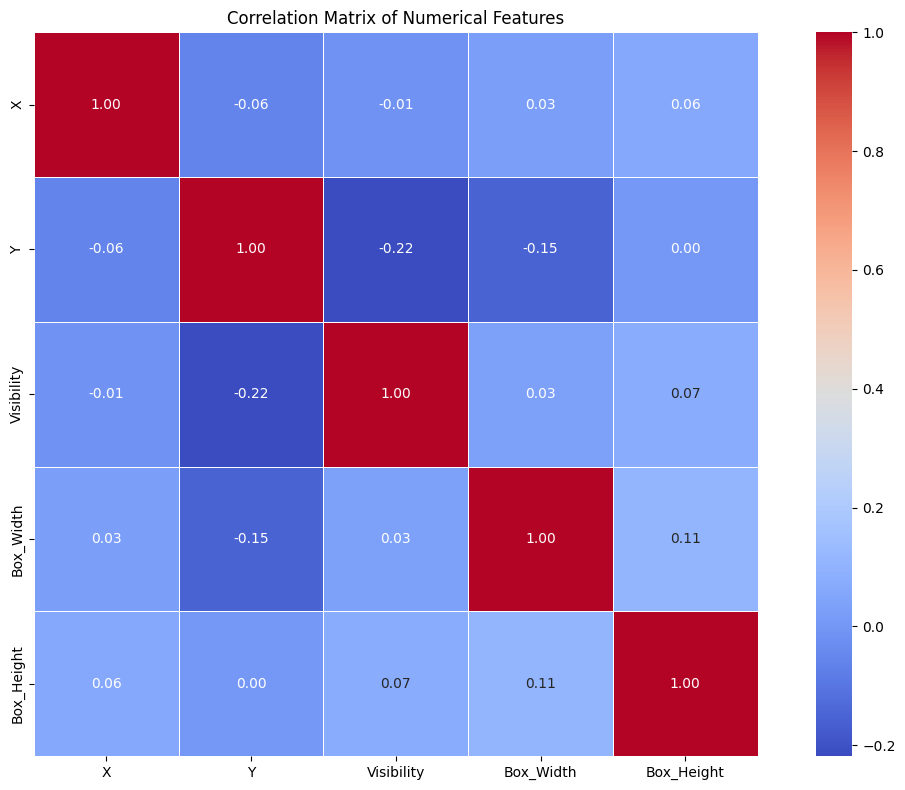

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = continuous_features

# Calculate the correlation matrix
corr_matrix = df[numerical_features].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()


## 2.15 Plotting out the information gain

> Information gain plots out how much a feature may help reduce uncertainty in a dataset. This in other words means that the feature helps in classifying certain outcomes (e.g. If a feature deduces a low information gain it means that it has little effect on the target variable)

Here I plotted out the information gain for each joint to see which joints were the most analysed when making a prediction to see if an individual was in the process of falling. This could then lead to pre-requisites to setting up the camera such that these joints are made to be the most visible

In the first code snippet below, the dataset is being reshaped such that each unique joint is made into a feature/column and then put up against the outcome label marking if the combinations of joints are a fall or not

Having reshaped the dataset what we get to see is the following:
- The most analyzed joints in a fall or non-fall
- What the average visibilities were based on how much they contributed to the outcome

In [2]:
import pandas as pd

# Load the pose data CSV
input_csv = "image_train_pose_coordinates.csv"
output_csv = "reshaped_pose_data.csv"

# Read the CSV into a DataFrame
pose_df = pd.read_csv(input_csv)

# Add a new column for the outcome label
pose_df["Label"] = pose_df["Image"].apply(
    lambda x: "Fall" if "fall" in x.lower() and "not" not in x.lower() else "Not Fall"
)

# Create a unique identifier for each image to reshape the data
pose_df["Image_Label"] = pose_df["Image"] + "_" + pose_df["Label"]

# Reshape the data: Pivot each joint's X, Y, and Visibility into separate columns
reshaped_df = pose_df.pivot(
    index="Image_Label",
    columns="Joint",
    values=["X", "Y", "Visibility"]
)

# Flatten the multi-index columns
reshaped_df.columns = [f"{stat}_{joint}" for stat, joint in reshaped_df.columns]

# Reset the index to include Image_Label as a column
reshaped_df = reshaped_df.reset_index()

# Split Image_Label back into Image and Label columns
reshaped_df[["Image", "Label"]] = reshaped_df["Image_Label"].str.split("_", n=1, expand=True)

# Drop the temporary Image_Label column
reshaped_df = reshaped_df.drop(columns=["Image_Label"])

# Save the reshaped DataFrame to a new CSV
reshaped_df.to_csv(output_csv, index=False)
print(f"Reshaped data saved to {output_csv}")

Reshaped data saved to reshaped_pose_data.csv


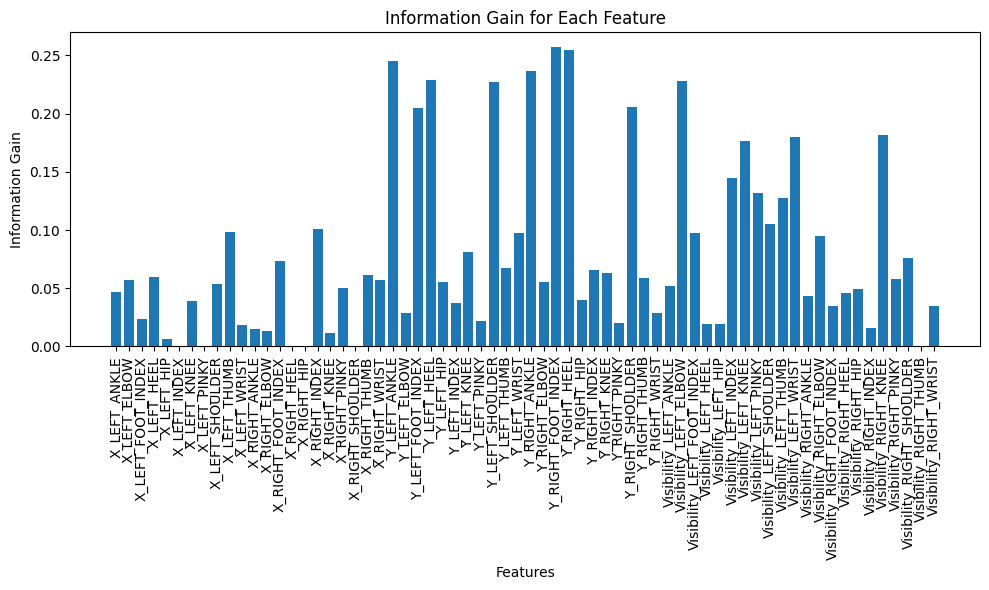

In [3]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import pandas as pd

# Load the reshaped data
data = pd.read_csv("reshaped_pose_data.csv")

# Separate features and target
X = data.drop(columns=["Image", "Label"])  # Drop non-feature columns
y = data["Label"]

# Encode the labels (if they are strings)
y_encoded = y.map({"Fall": 1, "Not Fall": 0}).astype(int)

# Compute mutual information (information gain)
info_gain = mutual_info_classif(X, y_encoded, discrete_features=False)

# Plot information gain
plt.figure(figsize=(10, 6))
plt.bar(X.columns, info_gain)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Information Gain")
plt.title("Information Gain for Each Feature")
plt.tight_layout()
plt.show()

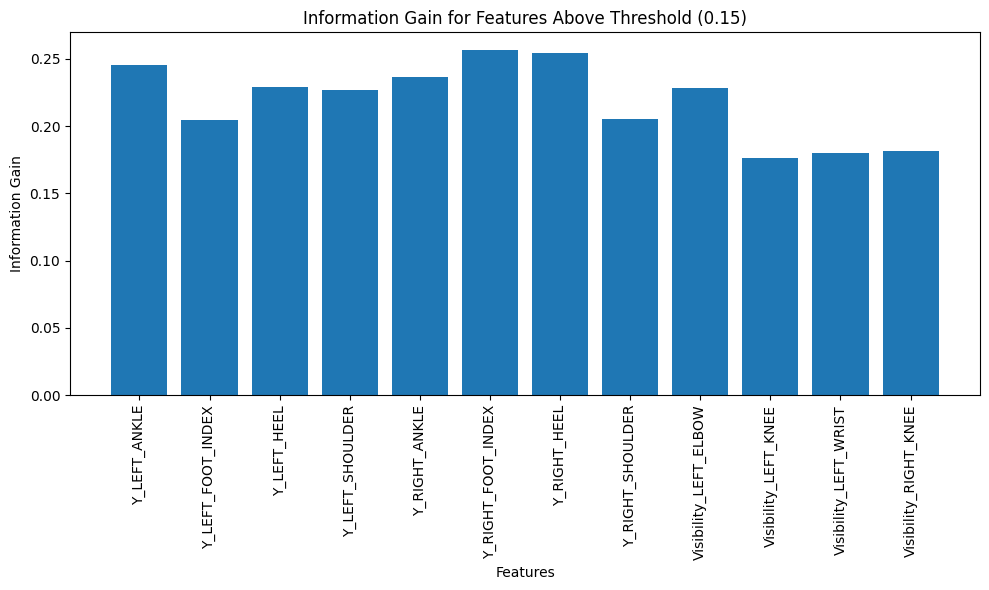

In [4]:
# Filter features with information gain > 0.15
selected_features = X.columns[info_gain > 0.15]
selected_info_gain = info_gain[info_gain > 0.15]

# Plot filtered information gain
plt.figure(figsize=(10, 6))
plt.bar(selected_features, selected_info_gain)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Information Gain")
plt.title("Information Gain for Features Above Threshold (0.15)")
plt.tight_layout()
plt.show()

# 3.0 Feature Engineering 

For the feature engineering section there may be one change made to the dataset and that is to implement the process of winsordizing to the numerical features that have outliers to replace them with capped values in order to reduce the variance in each model during the training process. However, given the relevance of each outlier (having justified them as extreme cases) they will not be removed

# 4.0 Data Pre-processing 

## 4.1 Train-Test split

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the CSV file
csv_path = "image_train_pose_coordinates.csv"
df = pd.read_csv(csv_path)

# Extract the target label (fall or no_fall) from the image name
df["Label"] = df["Image"].apply(lambda x: 1 if x.lower().startswith("fall") else 0)

# Features and target
features = ["X", "Y", "Visibility", "Box_Width", "Box_Height"]
X = df[features]
y = df["Label"]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)# Test size set to 20%

# Count the number of falls and non-falls
fall_counts = df["Label"].value_counts()

# Display the counts
print("Number of non-falls:", fall_counts[0])
print("Number of falls:", fall_counts[1])

Number of non-falls: 3124
Number of falls: 3784


# Assessing which model is the most optimal

> A cross validation is to be carried out amongst the mentioned models such that the model that performs the best will be used towards the end for real time predictions

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Define the models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Classifier": SVC(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Iterate over the models and perform cross-validation
for model_name, model in models.items():
    # Perform 5-fold cross-validation and print the mean accuracy score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{model_name} - Cross-validation mean accuracy: {cv_scores.mean():.4f}")

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test set and evaluate
    y_pred = model.predict(X_test)
    print(f"Accuracy of {model_name}: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


Logistic Regression - Cross-validation mean accuracy: 0.7570
Accuracy of Logistic Regression: 0.7641
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       596
           1       0.79      0.80      0.79       786

    accuracy                           0.76      1382
   macro avg       0.76      0.76      0.76      1382
weighted avg       0.76      0.76      0.76      1382

--------------------------------------------------
Support Vector Classifier - Cross-validation mean accuracy: 0.8194
Accuracy of Support Vector Classifier: 0.8119
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       596
           1       0.82      0.85      0.84       786

    accuracy                           0.81      1382
   macro avg       0.81      0.81      0.81      1382
weighted avg       0.81      0.81      0.81      1382

--------------------------------------------------
Random Forest - Cross-validati

# Utilizing a logistic Regression Model

In terms of the performance the Logisitc regression model had retainined an above average performance in terms of its accuracy (>75%). However, given its low macro accuracy it may have to be negated before being deployed

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

# Evaluate the model
y_pred = LR_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.76410998552822
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       596
           1       0.79      0.80      0.79       786

    accuracy                           0.76      1382
   macro avg       0.76      0.76      0.76      1382
weighted avg       0.76      0.76      0.76      1382


# Plotting the ROC curve

> This shows the total true positives detected against the number of false positives, hence showing how accurate the model is in detecting falls in terms of comparing its true positive rate against its false positive rate

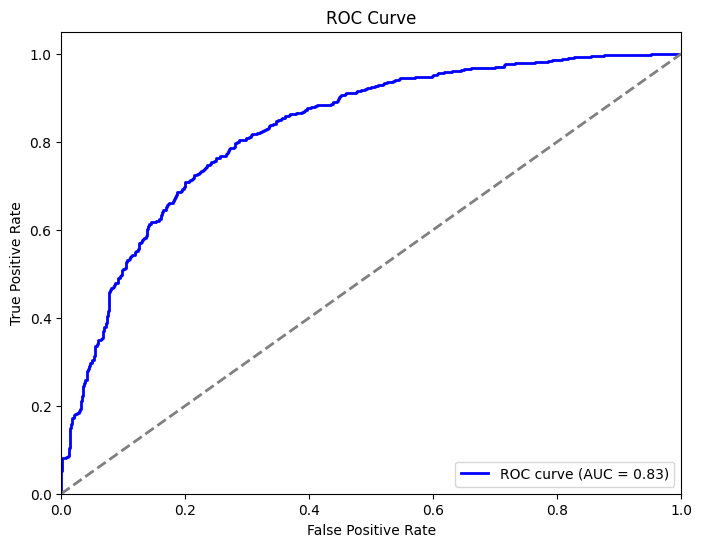

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict the probabilities of the positive class
y_prob = LR_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [8]:
import cv2 as cv
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Define indices of non-face landmarks
non_face_indices = list(range(11, 33))  # Excluded joint range for facial features

cap = cv.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break

        # Preprocess frame
        image = cv.resize(frame, (640, 480))
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Detect pose landmarks
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            height, width, _ = image.shape
            landmarks = results.pose_landmarks.landmark

            # Filter non-face landmarks
            filtered_landmarks = [landmarks[i] for i in non_face_indices]

            # Extract features for prediction
            x_coords = [lm.x * width for lm in filtered_landmarks]
            y_coords = [lm.y * height for lm in filtered_landmarks]
            visibilities = [lm.visibility for lm in filtered_landmarks]

            # Calculate bounding box
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            box_width = x_max - x_min
            box_height = y_max - y_min

            # Prepare input for the model
            features_input = np.array([np.mean(x_coords), np.mean(y_coords), np.mean(visibilities), box_width, box_height])
            features_input_scaled = scaler.transform([features_input])

            # Make prediction
            prediction = LR_model.predict(features_input_scaled)[0]
            label = "Falling" if prediction == 1 else "Not Falling"

            # Annotate the frame
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
            )
            cv.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            cv.putText(frame, label, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Display the frame
        cv.imshow("Fall Detection", frame)

        # Break loop on 'q' key press
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv.destroyAllWindows()


C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but St

# Tuning a KNN model

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the KNN model
knn_model = KNeighborsClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': range(1, 21),  # Test n_neighbors from 1 to 20
    'weights': ['uniform', 'distance'],  # Test uniform and distance-based weighting
    'p': [1, 2]  # Test Manhattan (1) and Euclidean (2) distance metrics
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring='accuracy',  # Evaluate models using accuracy
    cv=5,  # Use 5-fold cross-validation
    verbose=2,  # Print progress during tuning
    n_jobs=-1  # Use all available processors
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Output the best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Train the model with the best parameters on the entire training set
best_knn_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_knn_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 80 candidates, totalling 400 fits


KeyboardInterrupt: 

## Utilizing the tuned KNN model

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  

# Train the model
knn_model.fit(X_train, y_train)

# Evaluate the model
y_pred = knn_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.8835021707670043
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       596
           1       0.91      0.88      0.90       786

    accuracy                           0.88      1382
   macro avg       0.88      0.88      0.88      1382
weighted avg       0.88      0.88      0.88      1382


# Plotting the ROC curve of a KNN model

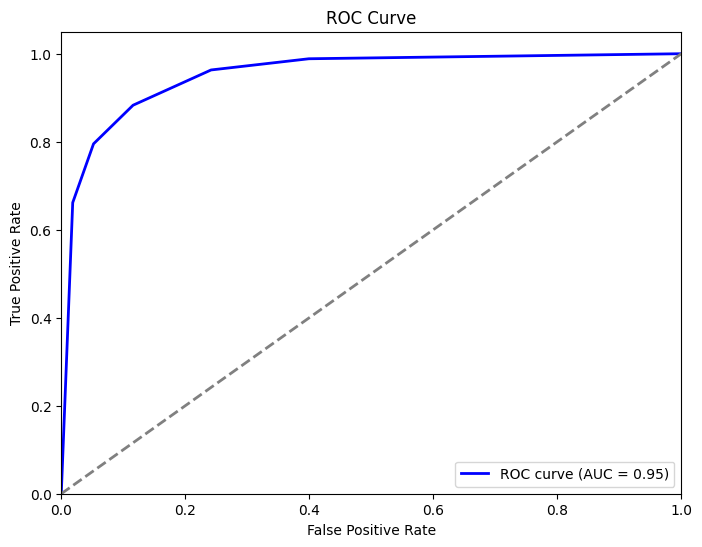

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict the probabilities of the positive class
y_prob = knn_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [9]:
import cv2 as cv
import mediapipe as mp
import numpy as np

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Define indices of non-face landmarks
non_face_indices = list(range(11, 33))  # Pose landmarks, excluding face-related ones

cap = cv.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break

        # Preprocess frame
        image = cv.resize(frame, (640, 480))
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Detect pose landmarks
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            height, width, _ = image.shape
            landmarks = results.pose_landmarks.landmark

            # Filter non-face landmarks
            filtered_landmarks = [landmarks[i] for i in non_face_indices]

            # Extract features for prediction
            x_coords = [lm.x * width for lm in filtered_landmarks]
            y_coords = [lm.y * height for lm in filtered_landmarks]
            visibilities = [lm.visibility for lm in filtered_landmarks]

            # Calculate bounding box
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            box_width = x_max - x_min
            box_height = y_max - y_min

            # Prepare input for the model
            features_input = np.array([np.mean(x_coords), np.mean(y_coords), np.mean(visibilities), box_width, box_height])
            features_input_scaled = scaler.transform([features_input])

            # Make prediction
            prediction = knn_model.predict(features_input_scaled)[0]
            label = "Falling" if prediction == 1 else "Not Falling"

            # Annotate the frame
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
            )
            cv.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            cv.putText(frame, label, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Display the frame
        cv.imshow("Fall Detection", frame)

        # Break loop on 'q' key press
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv.destroyAllWindows()


C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but St

# Logging falls detected using a KNN model

The following code snippet logs the total number of falls detected and has a counter to record all the falls that lasted over 5 seconds (suggesting that there be some significance to falls that have such a duration)

In [4]:
import cv2 as cv
import mediapipe as mp
import numpy as np
import csv
import time

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Define indices of non-face landmarks
non_face_indices = list(range(11, 33))  # Pose landmarks, excluding face-related ones

cap = cv.VideoCapture(0)

fall_count = 0
long_fall_count = 0
fall_start_time = None
non_fall_start_time = time.time()
fall_durations = []
non_fall_durations = []

data_log = []  # Store data before saving to CSV

with mp_pose.Pose(min_detection_confidence=0.3, min_tracking_confidence=0.3) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break

        image = cv.resize(frame, (640, 480))
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        results = pose.process(image_rgb)

        if results.pose_landmarks:
            height, width, _ = image.shape
            landmarks = results.pose_landmarks.landmark
            filtered_landmarks = [landmarks[i] for i in non_face_indices]

            x_coords = [lm.x * width for lm in filtered_landmarks]
            y_coords = [lm.y * height for lm in filtered_landmarks]
            visibilities = [lm.visibility for lm in filtered_landmarks]

            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)
            box_width = x_max - x_min
            box_height = y_max - y_min

            features_input = np.array([np.mean(x_coords), np.mean(y_coords), np.mean(visibilities), box_width, box_height])
            features_input_scaled = scaler.transform([features_input])

            prediction = knn_model.predict(features_input_scaled)[0]
            label = "Falling" if prediction == 1 else "Not Falling"

            # Track durations of fall and non-fall events
            current_time = time.time()
            if prediction == 1:
                if fall_start_time is None:
                    fall_start_time = current_time
                    non_fall_durations.append(current_time - non_fall_start_time)
                fall_count += 1
            else:
                if fall_start_time is not None:
                    fall_duration = current_time - fall_start_time
                    fall_durations.append(fall_duration)
                    if fall_duration > 5:
                        long_fall_count += 1
                    fall_start_time = None
                non_fall_start_time = current_time

            data_log.append([round(current_time, 2), label])

            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2),
            )
            cv.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
            cv.putText(frame, label, (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        cv.imshow("Fall Detection", frame)
        if cv.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv.destroyAllWindows()

# Save log data to CSV
with open("fall_detection_log.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Timestamp", "Status"])
    writer.writerows(data_log)

print(f"Total Falls Detected: {fall_count}")
print(f"Falls Lasting Over 5 Seconds: {long_fall_count}")
print(f"Fall Durations (s): {fall_durations}")
print(f"Non-Fall Durations (s): {non_fall_durations}")


C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Ethan\.virtualenvs\Pose_Estimation\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but St

Total Falls Detected: 165
Falls Lasting Over 5 Seconds: 1
Fall Durations (s): [1.9699664115905762, 0.08700013160705566, 0.09099841117858887, 0.4460010528564453, 0.2069990634918213, 0.5549988746643066, 8.774999141693115, 0.15203380584716797]
Non-Fall Durations (s): [0.14903545379638672, 0.10100126266479492, 0.07799768447875977, 0.06699752807617188, 0.05999898910522461, 0.059001922607421875, 0.06800293922424316, 0.06399893760681152]


# Plotting out the falls against non-falls detected during an active feed

In [9]:
import csv
import matplotlib.pyplot as plt

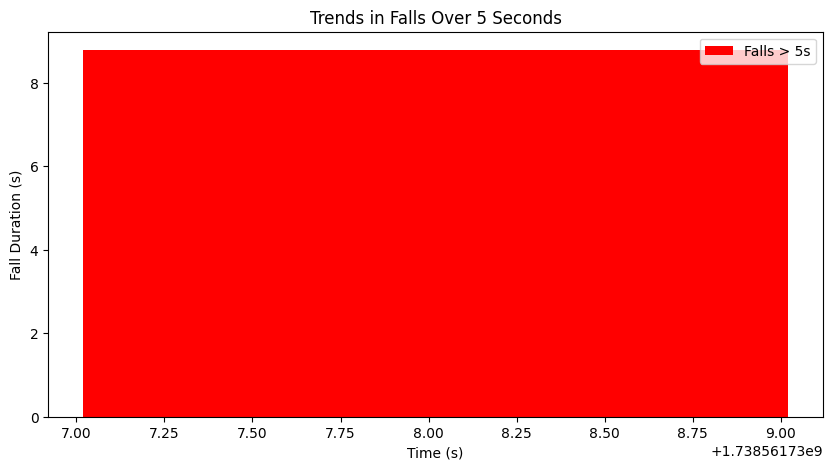

In [5]:
def read_fall_data(filename):
    falls_over_5s = []
    with open(filename, "r") as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        start_time = None

        for row in reader:
            timestamp, status = float(row[0]), row[1]
            if status == "Falling":
                if start_time is None:
                    start_time = timestamp
            else:
                if start_time is not None:
                    duration = timestamp - start_time
                    if duration > 5:
                        falls_over_5s.append((start_time, duration))
                    start_time = None
    return falls_over_5s

def plot_fall_trends(falls_over_5s):
    if not falls_over_5s:
        print("No falls over 5 seconds detected.")
        return

    times, durations = zip(*falls_over_5s)

    plt.figure(figsize=(10, 5))
    plt.bar(times, durations, width=2, color='red', label='Falls > 5s')
    plt.xlabel("Time (s)")
    plt.ylabel("Fall Duration (s)")
    plt.title("Trends in Falls Over 5 Seconds")
    plt.legend()
    plt.show()

# Read data and plot
falls_data = read_fall_data("fall_detection_log.csv")
plot_fall_trends(falls_data)


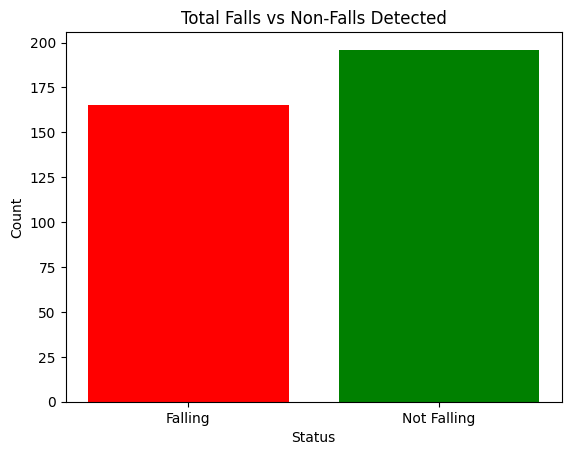

In [7]:
# Read the CSV file
fall_counts = {"Falling": 0, "Not Falling": 0}

data_log = []

with open("fall_detection_log.csv", "r") as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        timestamp, status = row
        fall_counts[status] += 1

# Plot bar chart
plt.bar(fall_counts.keys(), fall_counts.values(), color=['red', 'green'])
plt.xlabel("Status")
plt.ylabel("Count")
plt.title("Total Falls vs Non-Falls Detected")
plt.show()


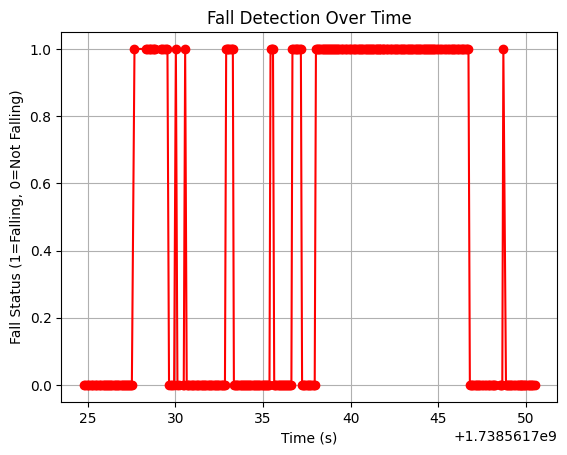

In [8]:
# Read the CSV file
timestamps = []
fall_labels = []

with open("fall_detection_log.csv", "r") as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        timestamp, status = row
        timestamps.append(float(timestamp))
        fall_labels.append(1 if status == "Falling" else 0)

# Plot falls over time
plt.plot(timestamps, fall_labels, marker='o', linestyle='-', color='red')
plt.xlabel("Time (s)")
plt.ylabel("Fall Status (1=Falling, 0=Not Falling)")
plt.title("Fall Detection Over Time")
plt.grid()
plt.show()